In [2]:
from pathlib import Path
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)

# for CVXPY implementation
from solardatatools.signal_decompositions import l1_l2d2p365 as cvx_sd
from solardatatools.signal_decompositions_l2norm import l1_l2d2p365 as cvx_sd_l2norm

# Import data from `tests/fixtures`

In [3]:
# Import data
fixtures_path = "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/"

data_file_path = Path(fixtures_path + "clear_day_detection/one_year_power_signals_1.csv")

with open(data_file_path) as file:
    data = np.loadtxt(file, delimiter=",")
expected_data_file_path = Path(fixtures_path + "clear_day_detection/one_year_weights_1.csv")

with open(expected_data_file_path) as file:
    expected_output = np.loadtxt(file, delimiter=",")

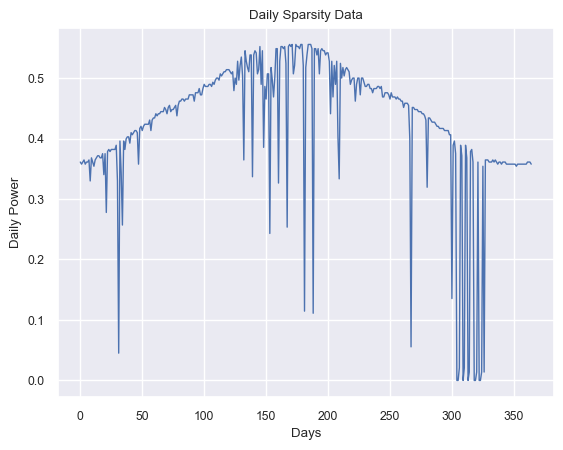

In [4]:
daily_sparsity = np.sum(data > 0.005 * np.max(data), axis=0)/288
plt.plot(daily_sparsity, linewidth=1);
plt.ylabel("Daily Power")
plt.xlabel("Days")
plt.title("Daily Sparsity Data")

# Current state: c1=1e3


MSE s_hat  (OSD,CVX)   2.94e-02


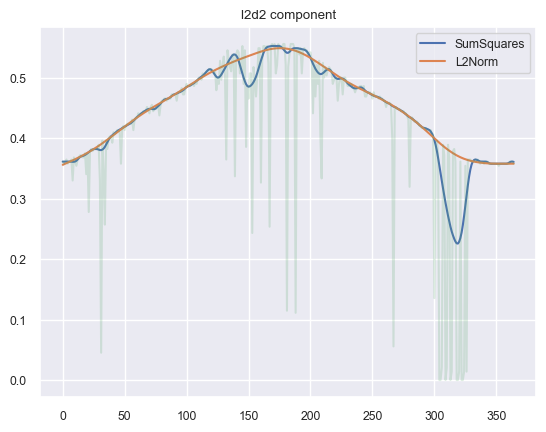

In [6]:
cvx_ss = cvx_sd(daily_sparsity, c1=1e3, solver="MOSEK")

cvx_l2n = cvx_sd_l2norm(daily_sparsity, c1=1e3, solver="MOSEK")

print(f'MSE s_hat  (OSD,CVX)   {mse(cvx_ss, cvx_l2n, squared=False):.2e}')

f, ax1, = plt.subplots(1, 1, sharex=True)
ax1.plot(cvx_ss, label="SumSquares")
ax1.plot(cvx_l2n, label="L2Norm")
ax1.plot(daily_sparsity, alpha=0.2)
ax1.set_title("l2d2 component")

ax1.legend()
plt.show()

# Optimize c1

In [7]:
results = {}
weight_iter = np.logspace(5.9, 6.1, 50)

def run(sig):
    mse_list = []
    for w in tqdm(weight_iter):
        res = cvx_sd(sig, c1=w, solver="MOSEK")
        mse_list.append(mse(cvx_l2n, res, squared=False))
        
    results["weight_min"] =  weight_iter[np.argmin(mse_list)]
    results["mse_min"] = np.min(mse_list)
    results["mse_list"] = mse_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.90it/s]


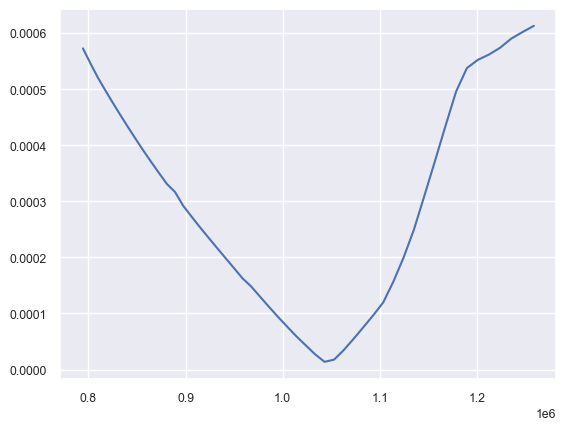

In [8]:
run(daily_sparsity)
plt.plot(weight_iter, results["mse_list"])

MSE s_hat  (OSD,CVX)   1.38e-05


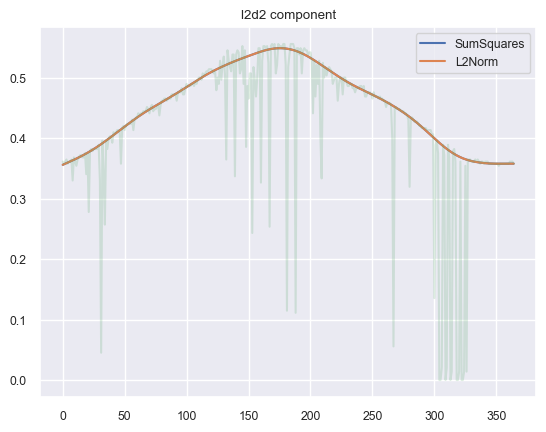

In [9]:
cvx_ss = cvx_sd(daily_sparsity, c1=results["weight_min"], solver="MOSEK")


print(f'MSE s_hat  (OSD,CVX)   {mse(cvx_ss, cvx_l2n, squared=False):.2e}')

f, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.plot(cvx_ss, label="SumSquares")
ax1.plot(cvx_l2n, label="L2Norm")
ax1.plot(daily_sparsity, alpha=0.2)
ax1.set_title("l2d2 component")

ax1.legend()
plt.show()

In [10]:
results["weight_min"]

1043199.4440463431